## Import Modules

Total audio files: 5600
First 5 paths: ['C:\\Users\\chada\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav', 'C:\\Users\\chada\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav', 'C:\\Users\\chada\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav', 'C:\\Users\\chada\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav', 'C:\\Users\\chada\\Downloads\\archive\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']
First 5 labels: ['angry', 'angry', 'angry', 'angry', 'angry']
                                              speech  label
0  C:\Users\chada\Downloads\archive\TESS Toronto ...  angry
1  C:\Users\chada\Downloads\archive\TESS Toronto ...  angry
2  C:\Users\chada\Downloads\archive\TESS Toronto ...  angry
3  C:\Users\chada\Downloads\archive\TESS Toronto ...  angry
4  C:\Users\chada\Downloads\archive\TESS Tor

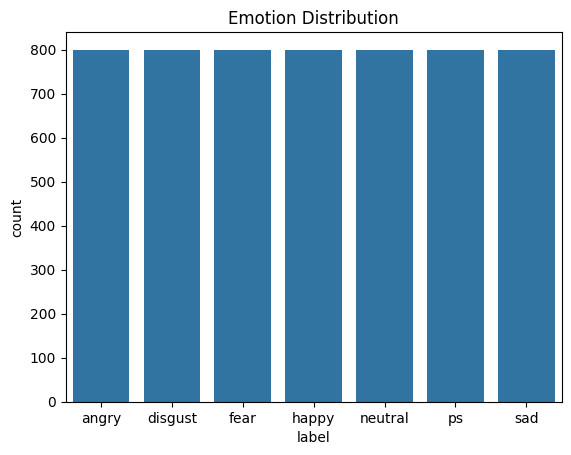

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# 1. Load dataset paths and labels
paths = []
labels = []
for dirname, _, filenames in os.walk(r"C:\Users\chada\Downloads\archive\TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split('.')[0]  # Extract label from filename
        labels.append(label.lower())  # Convert to lowercase for consistency

# Debugging: Verify paths and labels
print(f"Total audio files: {len(paths)}")
print(f"First 5 paths: {paths[:5]}")
print(f"First 5 labels: {labels[:5]}")

# 2. Create a DataFrame
df = pd.DataFrame({'speech': paths, 'label': labels})
print(df.head())

# 3. Check label distribution
print(df['label'].value_counts())
sns.countplot(data=df, x='label')
plt.title('Emotion Distribution')
plt.show()


## Load the Dataset

In [2]:
# 4. Define feature extraction function with additional features
def extract_features(filename):
    try:
        y, sr = librosa.load(filename, duration=3, offset=0.5)  # Load audio file
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
        return np.hstack((mfcc, chroma, mel))  # Concatenate features
    except Exception as e:
        print(f"Error extracting features from {filename}: {e}")
        return np.zeros(40 + 12 + 128)  # Handle errors with placeholder features

# 5. Apply feature extraction to dataset
df['features'] = df['speech'].apply(lambda x: extract_features(x))

# 6. Prepare input data as NumPy arrays
X = np.array(df['features'].tolist())
print(f"Feature array shape: {X.shape}")

# 7. Expand dimensions to match LSTM input requirements
X = np.expand_dims(X, -1)
print(f"Expanded feature shape: {X.shape}")


Feature array shape: (5600, 180)
Expanded feature shape: (5600, 180, 1)


In [3]:
from sklearn.preprocessing import OneHotEncoder

# 8. Encode labels as one-hot vectors
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()
print(f"One-hot encoded labels shape: {y.shape}")


One-hot encoded labels shape: (5600, 7)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# 9. Define the model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y.shape[1], activation='softmax')  # Match the number of classes
])

# 10. Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,583 (471.03 KB)

 Trainable params: 120,583 (471.03 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# 11. Set up callbacks
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_emotion_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# 12. Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64, callbacks=[lr_reducer, checkpoint])

# 13. Save the final model
model.save('final_emotion_recognition_model.h5')


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2019 - loss: 1.8941
Epoch 1: val_accuracy improved from -inf to 0.21607, saving model to best_emotion_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.2025 - loss: 1.8931 - val_accuracy: 0.2161 - val_loss: 1.6829 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3340 - loss: 1.6684
Epoch 2: val_accuracy did not improve from 0.21607
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.3345 - loss: 1.6670 - val_accuracy: 0.0786 - val_loss: 1.8230 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4529 - loss: 1.4054
Epoch 3: val_accuracy improved from 0.21607 to 0.28036, saving model to best_emotion_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.4524 - loss: 1.4062 - val_accuracy: 0.2804 - val_loss: 1.5423 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3966 - loss: 1.4501
Epoch 4: val_accuracy improved from 0.28036 to 0.37143, saving model to best_emotion_model.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.3972 - loss: 1.4488 - val_accuracy: 0.3714 - val_loss: 1.4649 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4491 - loss: 1.4659
Epoch 5: val_accuracy did not improve from 0.37143
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4478 - loss: 1.4714 - val_accuracy: 0.1786 - val_loss: 1.9791 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1733 - loss: 1.9476
Epoch 6: val_accuracy did not improve from 0.37143
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.1732 - loss: 1.9477 - val_accuracy: 0.1071 - val_loss: 1.9627 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1645 - loss: 1.9423
Epoch 7: val_accuracy did not improve from 0.37143
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.1647 - loss: 1.9423 - val_accuracy: 0.0000e+00 - val_loss: 1.9803 - learning_rate: 0.0010
Epoch 8/50
70/70 ━━

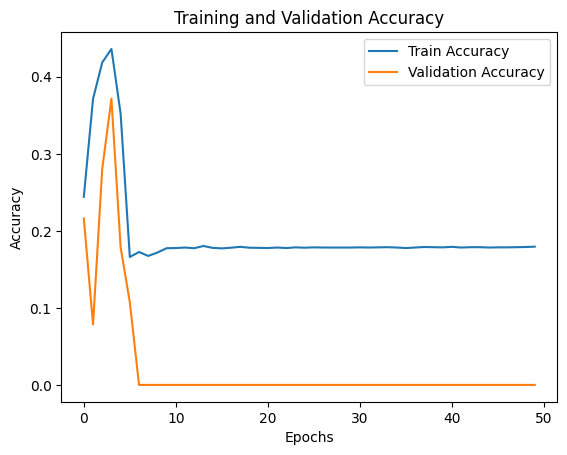

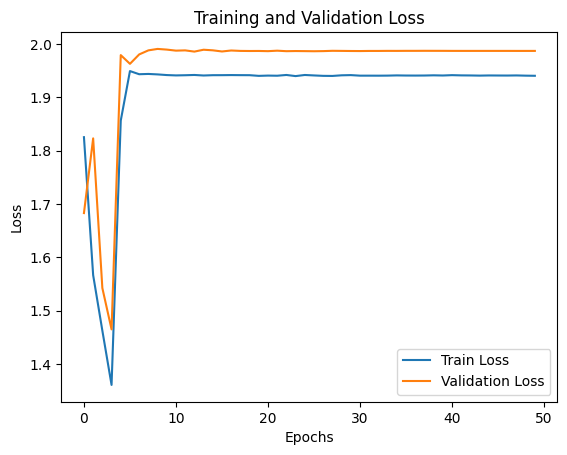

In [6]:
# 14. Plot accuracy
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 15. Plot loss
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


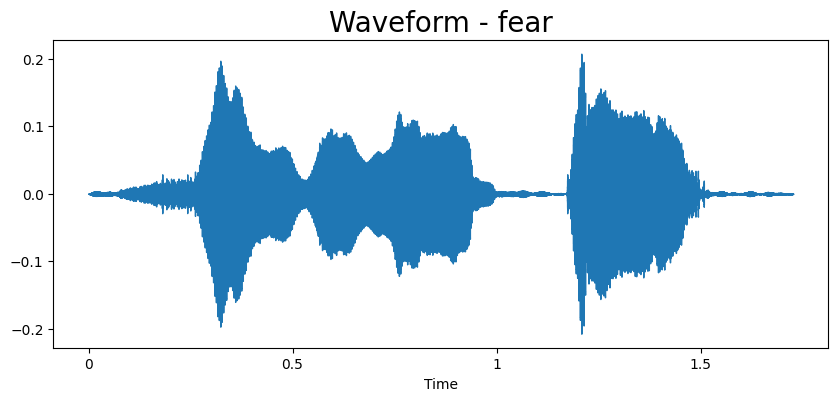

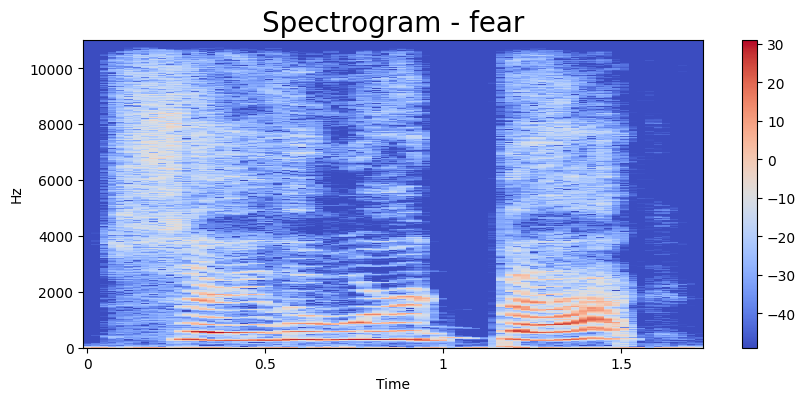

In [7]:
# 16. Test with an example file
emotion = 'fear'  # Change as needed
test_path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(test_path)

# 17. Visualize the waveform and spectrogram
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveform - {emotion}", size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10, 4))
    plt.title(f"Spectrogram - {emotion}", size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# 18. Play the audio
Audio(test_path)
